## Twitter Streams - Filters - Mining - Sentiment - Trends
Extracting two days worth of tweets using tweepy Twitter a Streaming API based on keyWords
<li/>Phone Models talked about around the day the iphoneX  was released 
<ol>
<ul>
<li/>iPhone (x)
<li/>Pixel (Google)
<li/>Nokia  (2)
<li/>Samsung (Galaxy)
</ul>
</ol>
Look for the influencers -those who have the most followers- 

<li/>The streams are geo localized and restricted to the New York area, more scpecifically the tweets are collected from Manhattan.

<li/>This notebook dicusses:
<ol>
<ul>
<li/>twitter API
<li/>Bloom Filters
<li/>Tweet Mining
<li/>Sentiment Analyses
<li/>Top Hashtags
</ul>
</ol>

## Getting Twitter API Keys
Access the Twitter Streaming API by registering an application to get an: 

<ul>
<li/>API key
<li/>API secret
<li/>Access token
<li/>Access token secret. 
</ul>


## Connecting to Twitter Streaming using tweepy

Using tweepy  - pip install tweepy

I have used Keywords to filter the strem:
list 1 : contains the different phone models 

I chose to limit the search to the nyc area - manhattan in particular
using a geo-box tool :
http://boundingbox.klokantech.com/
I got the coordinates of the manhttan island by drawing the area I wanted to filter
and added in the stream filter as a list for the 'locations ='
you need four data points for a bounding box 

I limited the language of the tweets selected to english using " lang = 'eng' "

In [ ]:
%%writefile twitter_streaming_phones.py
# %load code/twitter_streaming.py
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#Variables that contains the user credentials to access Twitter API 
access_token = "782193883786522624-7kT582Uhb8ZpRXsfhspYBf1HlQRYKTF"
access_token_secret = "rHSomVYGn6WqFeyrzaaoET0C0JIGyszEf2todq8yUGj4b"
consumer_key = "ZoqwB9CD8hbbzpY9uGTM98jsf"
consumer_secret = "IsSjto7UIRwukj8BH4IqwAHAhsm9Pa2ptDzrwp1NWAEGaIqgwE"

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        print data
        return True

    def on_error(self, status):
        print status


if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)
    
    #This line filter Twitter Streams to capture data by the keywords
    stream.filter(track=['Pixel', 'iPhone', 'Nokia', 'Samsung'], locations =[-74.0337066818,40.6918846491,-73.9076385414,40.8778028027], languages=["en"])

### Collecting Tweets and saving them in a text file

+ Tweets collected around the day of the release of the iphonex in NYC (11/04-11/25) written in 2 files

In [ ]:
import sys
sys.stdout = open('tweets_phones_NY_allphones.txt', 'a')
#sys.stdout = open('tweets_phones_NY_allphones1.txt', 'a')
%run twitter_streaming_phones.py

### Creating DataFrame from JSON 

In [1]:
import json
import pandas as pd
tweets_data_path = 'tweets_phones_NY_allphones.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        t = json.loads(line)
        if (type(t) == dict):
            tweet = t
            tweets_data.append(tweet)
    except:
        continue
        
print len(tweets_data) ##405134 tweets collected - takes some time to load

405134


## Creating the DataFrame
+ When we are dealng with a big data sets, errors occurs where missing values will throw exceptions
+ Dealing with these cases by taking care of the missing values while filling the dataframe with 'None'

In [2]:
tweets = pd.DataFrame()

tweets['text'] = [tweet.get('text', None) for tweet in tweets_data]
tweets['created_at'] = [tweet.get('created_at',None) for tweet in tweets_data]
tweets['username'] = [tweet.get('user').get('screen_name', '') if tweet.get('user', None) != None else None for tweet in tweets_data]
tweets['followers_count'] = [tweet.get('user').get('followers_count') if tweet.get('user', None) != None else None for tweet in tweets_data]

In [3]:
tweets.head(2)

,text,created_at,username,followers_count
0,RT @ILoveNadal1: Top investment fund manager f...,Sat Nov 04 00:48:56 +0000 2017,ffmicol,3668
1,RT @l0VELEXXX_: apple need to get it together....,Sat Nov 04 00:48:56 +0000 2017,tasiah_lawson,1866


In [4]:
tweets.apply(lambda x: sum(x.isnull()),axis=0)
## count of missing values in each colum

text                408
created_at          370
username            518
followers_count    1004
dtype: int64

### remove null rows

In [6]:
tweets = tweets[tweets.text.notnull()]
tweets = tweets[tweets.followers_count.notnull()]
tweets = tweets[tweets.created_at.notnull()]
## Test to see if they are gone
tweets.apply(lambda x: sum(x.isnull()),axis=0)

text               0
created_at         0
username           0
followers_count    0
dtype: int64

# Bloom filter in python
#### A Bloom filter is a space-efficient probabilistic data structure, conceived by Burton Howard Bloom in 1970, that is used to test whether an element is a member of a set
##### install pip pybloom
+ documentation available at https://github.com/jaybaird/python-bloomfilter/

In [9]:
from pybloom import BloomFilter

# create filter to store and set a (high) capacity
f = BloomFilter(capacity=100000, error_rate=0.001)

+ populating the data structure with numbers from 0-9 using the add method

In [10]:
print [f.add(x) for x in range(10)]
#** output > [False, False, False, False, False, False, False, False, False, False]

[False, False, False, False, False, False, False, False, False, False]


+ Testing to see if the numbers are in the datadtructure

In [11]:
print all([(x in f) for x in range(10)])

#** output > True

# unique testing
print 10 in f

#** output > False

print 5 in f

#** output > True

True
False
True


### BloomFilters on our 2 days worth of tweets data

#### Removing StopWords and links

In [12]:
from nltk.corpus import stopwords
import re

# find links 
def extract_link(text):
    regex = r'(https?://[\d\w\./\-\_\?]+)'
    try:
        match = re.search(regex, text)
        if match:
            return match.group()
        else:
            return ''
    except:
        return '-'

# remove links
def remove_links(text):
    return (re.sub(extract_link(text), '', text))

# remove stop words and links
def preprocess2(raw_text):
    raw_text = raw_text.encode('utf-8')
    stopword_set = set(stopwords.words("english")) # to remove words in this set of stop words
    raw_text = remove_links(raw_text)
    return " ".join([i for i in re.sub(r'[^a-zA-Z\s]', "", raw_text).lower().split() if i not in stopword_set])


In [13]:
tweets['processed_text'] = [preprocess2(tweet) for tweet in tweets['text']]
tweets.head(5)

,text,created_at,username,followers_count,processed_text
0,RT @ILoveNadal1: Top investment fund manager f...,Sat Nov 04 00:48:56 +0000 2017,ffmicol,3668,rt ilovenadal top investment fund manager geor...
1,RT @l0VELEXXX_: apple need to get it together....,Sat Nov 04 00:48:56 +0000 2017,tasiah_lawson,1866,rt lvelexxx apple need get together still seei...
2,Iphone X 😍😍😍,Sat Nov 04 00:48:56 +0000 2017,maurenggg,453,iphone x
3,RT @GemmaAnneStyles: It’s Friday night and our...,Sat Nov 04 00:48:56 +0000 2017,FerHiOopsLS,81,rt gemmaannestyles friday night flat smells li...
4,RT @Phil_Lewis_: I hope they find those 3 phon...,Sat Nov 04 00:48:57 +0000 2017,_amirahmad1,240,rt phillewis hope find phones


### Training the bloom filter on the tweets collected
+ Very fast data structure

In [14]:
from pybloom import BloomFilter

bloom = BloomFilter(capacity=10000000, error_rate=0.001)
tweets['filter'] = tweets['processed_text'].apply(lambda tweet: bloom.add(tweet), tweet)

In [22]:
tweets.head(5)

,text,created_at,username,followers_count,processed_text,filter
0,RT @ILoveNadal1: Top investment fund manager f...,Sat Nov 04 00:48:56 +0000 2017,ffmicol,3668,rt ilovenadal top investment fund manager geor...,False
1,RT @l0VELEXXX_: apple need to get it together....,Sat Nov 04 00:48:56 +0000 2017,tasiah_lawson,1866,rt lvelexxx apple need get together still seei...,False
2,Iphone X 😍😍😍,Sat Nov 04 00:48:56 +0000 2017,maurenggg,453,iphone x,False
3,RT @GemmaAnneStyles: It’s Friday night and our...,Sat Nov 04 00:48:56 +0000 2017,FerHiOopsLS,81,rt gemmaannestyles friday night flat smells li...,False
4,RT @Phil_Lewis_: I hope they find those 3 phon...,Sat Nov 04 00:48:57 +0000 2017,_amirahmad1,240,rt phillewis hope find phones,False


#### Get the tweets collected from different text file (collected roughly concurrently with the first stream)

In [ ]:
tweets_data_path_2 = 'tweets_phones_NY_allphones1.txt'

tweets_data_2 = []
tweets_file_2 = open(tweets_data_path_2, "r")
for line in tweets_file_2:
    try:
        t_2 = json.loads(line)
        if (type(t_2) == dict):
            tweet_2 = t_2
            tweets_data_2.append(tweet_2)
    except:
        continue

+ data frame get text only to test bloom filter

In [218]:
tweets_2 = pd.DataFrame()

tweets_2['text'] = [tweet_2.get('text', None) for tweet_2 in tweets_data_2]

tweets_2.head(5)

,text
0,"If you're looking for work in #Folsom, NJ, che..."
1,Incredible https://t.co/WYTpHmykXu
2,Find him https://t.co/iFa1YHUB0R
3,"it’s ok bruh, sometimes our girl puts us over ..."
4,RT @cloutboyjojo: now it’s your iPhone ex http...


#### prepocess remove stop words and links

In [262]:
#Remove nulls
tweets_2 = tweets[tweets.text.notnull()]

## preorocess text
tweets_2['processed_text'] = [preprocess2(tweet_2) for tweet_2 in tweets_2['text']]
tweets_2.head(5)

,text,processed_text
0,"If you're looking for work in #Folsom, NJ, che...",youre looking work folsom nj check job labor h...
1,Incredible https://t.co/WYTpHmykXu,incredible
2,Find him https://t.co/iFa1YHUB0R,find
3,"it’s ok bruh, sometimes our girl puts us over ...",ok bruh sometimes girl puts us top
4,RT @cloutboyjojo: now it’s your iPhone ex http...,rt cloutboyjojo iphone ex


### Apply the bloom filter on this new data set

In [266]:
tweets_2['filter'] = tweets_2['processed_text'].apply(lambda tweet_2: bloom.add(tweet_2), tweet_2)
tweets_2.head(5)

,text,processed_text,filter
0,"If you're looking for work in #Folsom, NJ, che...",youre looking work folsom nj check job labor h...,False
1,Incredible https://t.co/WYTpHmykXu,incredible,True
2,Find him https://t.co/iFa1YHUB0R,find,False
3,"it’s ok bruh, sometimes our girl puts us over ...",ok bruh sometimes girl puts us top,False
4,RT @cloutboyjojo: now it’s your iPhone ex http...,rt cloutboyjojo iphone ex,True


## Result of matched to unmatched tweets

In [271]:
filtered_tweets = tweets_2.groupby(['filter'])
filtered_tweets.size()

filter
False       274
True     170315
dtype: int64

### Ploting Results

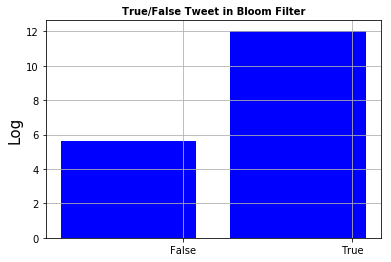

In [274]:
result = [False, True]
numbers = [np.log(filtered_tweets.size()[0]) , np.log(filtered_tweets.size()[1]) ] 
x_pos = list(range(len(result)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, numbers, width, alpha=1, color='b')

# Setting axis labels and ticks
ax.set_ylabel('Log', fontsize=15)
ax.set_title('True/False Tweet in Bloom Filter', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(result)
plt.grid()

The number of tweets that were already in the dataframe was surprisingly really high even if the streams were done concurrently. The streaming API returns a % of the total tweets also. 

## Mining the tweets

Compare popularity of the keywords: how much of the twitter sphere does the iphone hold compare to the other phone brands aroud the time of the release date

### log scaling for influencers talking about these phone

In [11]:
tweets['followers_count'].max()
tweet = tweets.sort_values(['followers_count'], ascending=[False])
tweet.drop(tweet.index[0], inplace=True) ##the max was not a number so was disregarded
tweet.head(4)

,text,coordinates,username,followers_count
337387,"Apple has $262bn of assets, $108bn of debt and...",None,TheEconomist,22295085
115280,"Apple has $262bn of assets, $108bn of debt and...",None,TheEconomist,22290881
93588,Apple’s free upgrade means that QR-scanning wi...,None,TheEconomist,22290396
305552,Review of the iPhone X: The new screen takes i...,None,WSJ,15069141


### most influencing account

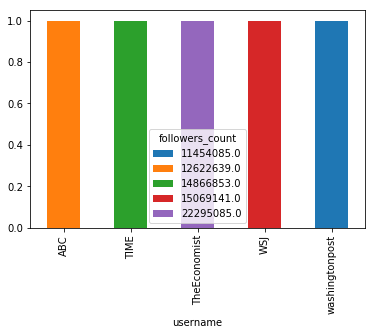

In [87]:
# Ge top accounts
influencers = tweet.head(10)
# remove duplicates
top_accounts = influencers.drop_duplicates(subset='username')
# histogram of results
top_accounts.groupby(["username","followers_count"]).size().unstack(level=-1).plot(kind='bar',stacked=True)

The accounts with the most followers are all News Companies. 

#### Range of accounts' number of followers talking about the phones

C:\Users\KVA\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


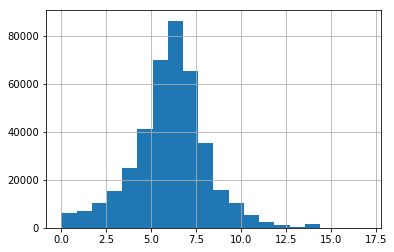

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tweet['followers_count'] = pd.to_numeric(tweet.followers_count)
tweets_followers = tweet.loc[tweet.followers_count != 0]
tweets_followers['followers_count_log'] = np.log(tweets_followers['followers_count'])
tweets_followers['followers_count_log'].hist(bins=20)

Our data set has tweets coming from influencial accounts. The distribution of number of followers is the common bell curved

### Finding Tweets with some KeyWords

In [307]:
import re
def word_in_text(word, text):
    if(text != None):
        word = word.lower()
        text = text.lower()
        match = re.search(word, text)
        if match:
            return True
        return False
    else:
        return False


In [358]:
# function that returns the number of tweets containing a specific keyword
def count_for_tweet(kword):
    tweets[kword] = tweets['processed_text'].apply(lambda tweet: word_in_text(kword, tweet))
    return tweets[kword].value_counts()[1] 

In [501]:
keywords = ['iPhone', 'apple', 'Nokia', 'Pixel', 'Samsung', 'Google', 'Galaxy']

keywords_count = []
for k in keywords:
    keywords_count.append(count_for_tweet(k))
    
for x in range(len(keywords)):
    print keywords[x], keywords_count[x]
    

iPhone 176688
apple 111867
Nokia 459
Pixel 2920
Samsung 2204
Google 4671
Galaxy 1621


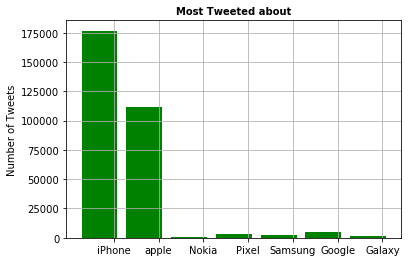

In [507]:
x_pos = list(range(len(keywords)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, keywords_count, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Number of Tweets', fontsize=10)
ax.set_title('Most Tweeted about', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(keywords)
plt.grid()

For the tweets collected on the launch of the iphoneX apple and the iphone keywords were great hits and the rest remains shy on the twittersphere. the iphone blows away the other models and competitions. 

## Sentiment Analysis

+ pip install textblob

Sentiment analysis refers to the use of natural language processing, text analysis and computational linguistics to identify and extract subjective information in source materials. 

+ https://codehackersblog.blogspot.com/2015/06/a-gentle-introduction-to-textblob-for.html

In [360]:
from textblob import TextBlob

## sentiment analyses of all the tweets containing a keyword
## already collected in dataFrame
def tweet_sentiment(column):
    t2 = tweets[tweets[column] == True]
    avg = 0
    count = len(t2['text'])
    for t in t2['text']:
        if (t != None):
            tweet = TextBlob(t)
            avg = tweet.sentiment.polarity + avg
        else:
            count = count - 1
    avg = avg/count
    return avg

In [361]:
## take Tweets containing these keywords 
keywords = ['iPhone', 'apple', 'Nokia', 'Pixel', 'Samsung', 'Google', 'Galaxy']

# Sentiment Analysis
keywords_sentiment = []
for k in keywords:
    keywords_sentiment.append(tweet_sentiment(k))
    
for x in range(len(keywords)):
    print keywords[x], keywords_sentiment[x]

iPhone 0.117942869944
apple 0.0810649180977
Nokia 0.180121216837
Pixel 0.208077018053
Samsung 0.218428138161
Google 0.141238763091
Galaxy 0.273125032594


A posititve value is interpreted as a good value.
A value of 0.0 indicates neutral, 0.5 indicates positive. Values which fall in between 0.4 and 0.5 are more or less positve. 
Now lets display both the polarity and subjectivity. The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. 

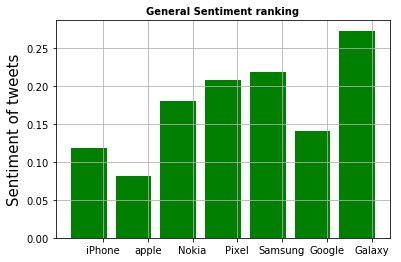

In [362]:
x_pos = list(range(len(keywords)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, keywords_sentiment, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Sentiment of tweets', fontsize=15)
ax.set_title('General Sentiment ranking', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(keywords)
plt.grid()

The sentiment polarity of the tweets for all the keywords are in the positive range
I expected the iphone or apple keywords to have a higher polarity since the tweets are on the day the iphone x was launched. Maybe people were complaining about the long lines in front of the apple store?

### Popular hashtag of dataset 

In [405]:
t = tweets['text'][0]
re.findall(r'\#[\S]+', t)

# returns a list of all the hashtags in a tweet
global hashtags
hashtags = []
def find_hashtags(text):
    list1 = re.findall(r'\#[\S]+', text)
    str1 = ' '.join(list1)
    global hashtags 
    hashtags.append(list1)
    return str1

tweets['hashtags'] = tweets['text'].apply(lambda tweet: find_hashtags(tweet))


In [486]:
# get the top 5 hashtags
import collections
from operator import itemgetter
cnt = collections.Counter()
for l in hashtags:
    for l2 in l:
        cnt[l2.encode('utf-8').lower()] += 1
top_hashtags = dict(cnt.most_common(5))
top_hashtags = collections.OrderedDict(sorted(top_hashtags.items(), key=itemgetter(1), reverse=True))
top_hashtags

OrderedDict([('#iphonex', 5748),
             ('#apple', 5396),
             ('#dolantwinsnewvideo', 3580),
             ('#iphone', 2481),
             ('#rm', 1534)])

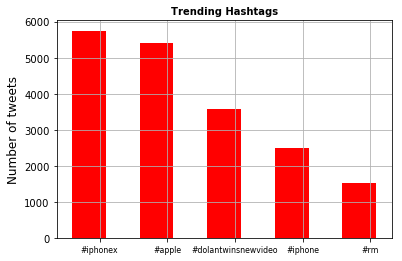

In [500]:
# Plot result
x_pos = list(range(len(top_hashtags)))
fig, ax = plt.subplots()
plt.bar(x_pos, top_hashtags.values(), 0.5, alpha=1, color='r')

# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=12)
ax.set_title('Trending Hashtags', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.2 * 0.8 for p in x_pos])
ax.set_xticklabels(top_hashtags.keys(), fontsize = 7.8)
plt.grid()

As expected #iphonex was trending and is the most popular hashtag in the data set. Corrolates with the launch. The 3rd is a viral hashtag that was trending just at this particular time